# RNN을 이용한 분류
- SMS Spam: ham/spam 분류
- Reuter News: 카테고리 분류
- IMDB Review: 감성분석 (긍정: 0/부정: 1)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

## 1. SMS Spam
- 사용 데이터셋 : [SMS Spam](https://www.kaggle.com/uciml/sms-spam-collection-dataset) (kaggle 제공)

### 파일 업로드

In [4]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving spam.csv to spam.csv


### 데이터 전처리

In [5]:
df = pd.read_csv(filename, encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [6]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
# ham: 0, spam: 1로 대체, LabelEncoding으로도 가능
df['v1'] = df['v1'].replace(['ham', 'spam'], [0, 1])    
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [8]:
# Null 값이 있는지 확인
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [9]:
# 데이터 중복이 있는지 확인
df['v2'].nunique()

5169

- 데이터의 중복이 존재함을 볼 수 있다.

In [10]:
# 데이터 중복 제거
df = df.drop_duplicates('v2', keep='first')

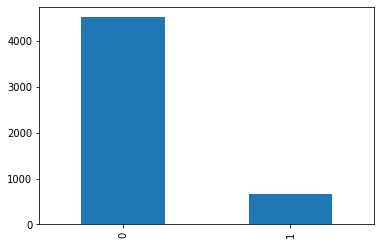

In [11]:
df['v1'].value_counts().plot(kind='bar');

In [12]:
df['v1'].value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [13]:
X_data = df['v2'].values
y_data = df['v1'].values
print(f'메일 본문의 개수: {len(X_data)}')
print(f'레이블의 개수: {len(y_data)}')

메일 본문의 개수: 5169
레이블의 개수: 5169


In [14]:
t = Tokenizer()
t.fit_on_texts(X_data)
sequences = t.texts_to_sequences(X_data)
vocab_size = len(t.word_index) + 1
print('단어 집합의 크기: %d' % vocab_size)

단어 집합의 크기: 8921


In [15]:
X_data = sequences

SMS의 최대 길이: 189
SMS의 평균 길이: 15.610370


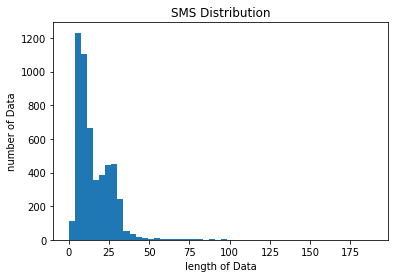

In [16]:
max_len = max(len(l) for l in X_data)
print('SMS의 최대 길이: %d' % max_len)
print('SMS의 평균 길이: %f' % (sum(map(len, X_data))/len(X_data)))

plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.title('SMS Distribution')
plt.show()

In [17]:
# 전체 데이터셋의 길이를 max_len(=189)에 맞춤
data = pad_sequences(X_data, maxlen=max_len)
data.shape

(5169, 189)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, y_data, stratify=y_data, test_size=0.2, random_state=seed
)

In [19]:
X_train.shape, X_test.shape

((4135, 189), (1034, 189))

### 모델 정의/설정/학습/평가

- SimpleRNN

In [20]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          285472    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 287,585
Trainable params: 287,585
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train, epochs=10, 
                    batch_size=60, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 10s 132ms/step - loss: 0.4026 - accuracy: 0.8539 - val_loss: 0.1451 - val_accuracy: 0.9565
Epoch 2/10
56/56 [==============================] - 7s 125ms/step - loss: 0.1132 - accuracy: 0.9700 - val_loss: 0.0675 - val_accuracy: 0.9819
Epoch 3/10
56/56 [==============================] - 7s 128ms/step - loss: 0.0593 - accuracy: 0.9858 - val_loss: 0.0510 - val_accuracy: 0.9891
Epoch 4/10
56/56 [==============================] - 7s 127ms/step - loss: 0.0340 - accuracy: 0.9915 - val_loss: 0.0560 - val_accuracy: 0.9819
Epoch 5/10
56/56 [==============================] - 7s 124ms/step - loss: 0.0194 - accuracy: 0.9962 - val_loss: 0.0653 - val_accuracy: 0.9794
Epoch 6/10
56/56 [==============================] - 7s 125ms/step - loss: 0.0115 - accuracy: 0.9975 - val_loss: 0.0723 - val_accuracy: 0.9794
Epoch 7/10
56/56 [==============================] - 7s 126ms/step - loss: 0.0116 - accuracy: 0.9966 - val_loss: 0.0865 - val_accuracy: 0.9782
Epoch

In [23]:
acc_spam_srnn = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'\nSimpleRNN 테스트 정확도: {acc_spam_srnn:.4f}')

33/33 - 0s - loss: 0.0597 - accuracy: 0.9836

SimpleRNN 테스트 정확도: 0.9836


In [24]:
del model

- GRU

In [25]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          285472    
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 291,841
Trainable params: 291,841
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', metrics=['accuracy'])

In [27]:
model.fit(X_train, y_train, epochs=10, 
                    batch_size=60, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 7s 19ms/step - loss: 0.4987 - accuracy: 0.8292 - val_loss: 0.1643 - val_accuracy: 0.9480
Epoch 2/10
56/56 [==============================] - 1s 11ms/step - loss: 0.1140 - accuracy: 0.9660 - val_loss: 0.0605 - val_accuracy: 0.9819
Epoch 3/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0454 - accuracy: 0.9883 - val_loss: 0.0506 - val_accuracy: 0.9867
Epoch 4/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0227 - accuracy: 0.9943 - val_loss: 0.0424 - val_accuracy: 0.9855
Epoch 5/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0125 - accuracy: 0.9980 - val_loss: 0.0461 - val_accuracy: 0.9867
Epoch 6/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0086 - accuracy: 0.9988 - val_loss: 0.0480 - val_accuracy: 0.9855
Epoch 7/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 0.0579 - val_accuracy: 0.9879
Epoch 8/10
56

In [28]:
acc_spam_gru = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'\nGRU 테스트 정확도: {acc_spam_gru:.4f}')

33/33 - 0s - loss: 0.0516 - accuracy: 0.9836

GRU 테스트 정확도: 0.9836


In [29]:
del model

- LSTM

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          285472    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 293,825
Trainable params: 293,825
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', metrics=['accuracy'])

In [32]:
model.fit(X_train, y_train, epochs=10, 
                    batch_size=60, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 3s 19ms/step - loss: 0.4429 - accuracy: 0.8384 - val_loss: 0.1650 - val_accuracy: 0.9722
Epoch 2/10
56/56 [==============================] - 1s 11ms/step - loss: 0.1345 - accuracy: 0.9692 - val_loss: 0.0800 - val_accuracy: 0.9819
Epoch 3/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0678 - accuracy: 0.9851 - val_loss: 0.0547 - val_accuracy: 0.9879
Epoch 4/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0320 - accuracy: 0.9928 - val_loss: 0.0496 - val_accuracy: 0.9879
Epoch 5/10
56/56 [==============================] - 1s 12ms/step - loss: 0.0181 - accuracy: 0.9968 - val_loss: 0.0664 - val_accuracy: 0.9794
Epoch 6/10
56/56 [==============================] - 1s 12ms/step - loss: 0.0158 - accuracy: 0.9976 - val_loss: 0.0466 - val_accuracy: 0.9843
Epoch 7/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0086 - accuracy: 0.9981 - val_loss: 0.0485 - val_accuracy: 0.9867
Epoch 8/10
56

In [33]:
acc_spam_lstm = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'\nLSTM 테스트 정확도: {acc_spam_lstm:.4f}')

33/33 - 0s - loss: 0.0560 - accuracy: 0.9865

LSTM 테스트 정확도: 0.9865


In [34]:
del model

In [35]:
SMS_acc_list = [acc_spam_srnn, acc_spam_gru, acc_spam_lstm]
SMS_acc_list = np.round(SMS_acc_list, 4)
SMS_acc_list

array([0.9836, 0.9836, 0.9865])

## 2. Reuter News

In [36]:
from tensorflow.keras.datasets import reuters
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=None, test_split=0.2
)

2113536/2110848 [==============================] - 0s 0us/step


In [37]:
# 데이터 확인하기
category = np.max(y_train) + 1
print('카테고리:', category)
print('학습용 뉴스 기사:', len(X_train))
print('테스트용 뉴스 기사:', len(X_test))

카테고리: 46
학습용 뉴스 기사: 8982
테스트용 뉴스 기사: 2246


In [38]:
index_dict = {}
for key, value in reuters.get_word_index().items():
    index_dict[value] = key
len(index_dict)

557056/550378 [==============================] - 0s 0us/step


30979

In [39]:
# 뉴스 기사의 길이
print('뉴스 기사의 최대 길이 :', max(len(l) for l in X_train))
print('뉴스 기사의 평균 길이 :', sum(map(len, X_train))/len(X_train))

뉴스 기사의 최대 길이 : 2376
뉴스 기사의 평균 길이 : 145.5398574927633


### 모델 생성/설정/학습/평가
- 모든 단어가 아닌 빈도수 1000 -> 5000까지 (총 단어수: 30,979)
- 모든 문장이 아니라 100 -> 500 단어까지 (최대 2,376 단어)

In [40]:
from tensorflow.keras.utils import to_categorical

#### 빈도수 1,000, 단어수 100 제한

In [41]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=1000, test_split=0.2
)

In [42]:
# 모델의 입력으로 사용하는 모든 뉴스 기사의 길이를 동일하게 100으로 맞춤
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [43]:
# 뉴스 기사 레이블의 One-hot encoding
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

- SimpleRNN

In [44]:
model = Sequential()
model.add(Embedding(1000, 120))
model.add(SimpleRNN(120))
model.add(Dense(46, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 120)         120000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 120)               28920     
_________________________________________________________________
dense_3 (Dense)              (None, 46)                5566      
Total params: 154,486
Trainable params: 154,486
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [46]:
# Callback 함수 정의 - Best model, Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model/reuter_srnn_100_best_model.h5', monitor='val_loss', 
                     mode='max', verbose=1, save_best_only=True)

In [47]:
model.fit(X_train, Y_train, batch_size=100, epochs=50, 
                    validation_split=0.2, verbose=2, callbacks=[mc, es])

Epoch 1/50
72/72 - 5s - loss: 2.5674 - accuracy: 0.3253 - val_loss: 2.3625 - val_accuracy: 0.3450

Epoch 00001: val_loss improved from -inf to 2.36254, saving model to model/reuter_srnn_100_best_model.h5
Epoch 2/50
72/72 - 5s - loss: 2.2245 - accuracy: 0.4117 - val_loss: 2.1780 - val_accuracy: 0.4140

Epoch 00002: val_loss did not improve from 2.36254
Epoch 3/50
72/72 - 5s - loss: 1.9956 - accuracy: 0.4906 - val_loss: 2.2192 - val_accuracy: 0.4619

Epoch 00003: val_loss did not improve from 2.36254
Epoch 4/50
72/72 - 5s - loss: 1.8364 - accuracy: 0.5312 - val_loss: 2.1738 - val_accuracy: 0.4196

Epoch 00004: val_loss did not improve from 2.36254
Epoch 5/50
72/72 - 5s - loss: 1.6006 - accuracy: 0.6000 - val_loss: 2.0753 - val_accuracy: 0.5036

Epoch 00005: val_loss did not improve from 2.36254
Epoch 6/50
72/72 - 5s - loss: 1.3930 - accuracy: 0.6554 - val_loss: 1.9216 - val_accuracy: 0.5053

Epoch 00006: val_loss did not improve from 2.36254
Epoch 7/50
72/72 - 5s - loss: 1.1976 - accurac

In [48]:
acc_reuter_srnn_100 = model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'\nSimpleRNN 테스트 정확도: {acc_reuter_srnn_100:.4f}')

71/71 - 0s - loss: 2.5896 - accuracy: 0.4973

SimpleRNN 테스트 정확도: 0.4973


In [49]:
del model

- GRU

In [50]:
model = Sequential()
model.add(Embedding(1000, 120))
model.add(GRU(120))
model.add(Dense(46, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 120)         120000    
_________________________________________________________________
gru_1 (GRU)                  (None, 120)               87120     
_________________________________________________________________
dense_4 (Dense)              (None, 46)                5566      
Total params: 212,686
Trainable params: 212,686
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [52]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model/reuter_gru_100_best_model.h5', monitor='val_loss', 
                     mode='max', verbose=1, save_best_only=True)

In [53]:
model.fit(X_train, Y_train, batch_size=100, epochs=50, 
                    validation_split=0.2, verbose=2, callbacks=[mc, es])

Epoch 1/50
72/72 - 2s - loss: 2.5508 - accuracy: 0.3567 - val_loss: 2.0155 - val_accuracy: 0.3895

Epoch 00001: val_loss improved from -inf to 2.01545, saving model to model/reuter_gru_100_best_model.h5
Epoch 2/50
72/72 - 1s - loss: 1.9184 - accuracy: 0.4582 - val_loss: 1.8186 - val_accuracy: 0.5025

Epoch 00002: val_loss did not improve from 2.01545
Epoch 3/50
72/72 - 1s - loss: 1.7499 - accuracy: 0.5421 - val_loss: 1.7528 - val_accuracy: 0.5492

Epoch 00003: val_loss did not improve from 2.01545
Epoch 4/50
72/72 - 1s - loss: 1.6792 - accuracy: 0.5719 - val_loss: 1.6838 - val_accuracy: 0.5710

Epoch 00004: val_loss did not improve from 2.01545
Epoch 5/50
72/72 - 1s - loss: 1.5982 - accuracy: 0.5939 - val_loss: 1.6408 - val_accuracy: 0.5932

Epoch 00005: val_loss did not improve from 2.01545
Epoch 6/50
72/72 - 1s - loss: 1.5309 - accuracy: 0.6127 - val_loss: 1.5692 - val_accuracy: 0.6110

Epoch 00006: val_loss did not improve from 2.01545
Epoch 7/50
72/72 - 1s - loss: 1.4691 - accuracy

In [54]:
acc_reuter_gru_100 = model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'\nGRU 테스트 정확도: {acc_reuter_gru_100:.4f}')

71/71 - 0s - loss: 1.4631 - accuracy: 0.6830

GRU 테스트 정확도: 0.6830


In [55]:
del model

LSTM

In [56]:
model = Sequential()
model.add(Embedding(1000, 120))
model.add(LSTM(120))
model.add(Dense(46, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 120)         120000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dense_5 (Dense)              (None, 46)                5566      
Total params: 241,246
Trainable params: 241,246
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [58]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model/reuter_lstm_100_best_model.h5', monitor='val_loss', 
                     mode='max', verbose=1, save_best_only=True)

In [59]:
model.fit(X_train, Y_train, batch_size=100, epochs=50, 
                    validation_split=0.2, verbose=2, callbacks=[mc, es])

Epoch 1/50
72/72 - 3s - loss: 2.6304 - accuracy: 0.3354 - val_loss: 2.3678 - val_accuracy: 0.3450

Epoch 00001: val_loss improved from -inf to 2.36778, saving model to model/reuter_lstm_100_best_model.h5
Epoch 2/50
72/72 - 1s - loss: 2.0737 - accuracy: 0.4621 - val_loss: 1.9117 - val_accuracy: 0.4975

Epoch 00002: val_loss did not improve from 2.36778
Epoch 3/50
72/72 - 1s - loss: 1.8264 - accuracy: 0.5189 - val_loss: 1.7499 - val_accuracy: 0.5437

Epoch 00003: val_loss did not improve from 2.36778
Epoch 4/50
72/72 - 1s - loss: 1.6974 - accuracy: 0.5605 - val_loss: 1.6864 - val_accuracy: 0.5743

Epoch 00004: val_loss did not improve from 2.36778
Epoch 5/50
72/72 - 1s - loss: 1.6513 - accuracy: 0.5795 - val_loss: 1.6601 - val_accuracy: 0.5965

Epoch 00005: val_loss did not improve from 2.36778
Epoch 6/50
72/72 - 1s - loss: 1.5478 - accuracy: 0.6113 - val_loss: 1.5345 - val_accuracy: 0.6171

Epoch 00006: val_loss did not improve from 2.36778
Epoch 7/50
72/72 - 1s - loss: 1.4466 - accurac

In [60]:
acc_reuter_lstm_100 = model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'\nLSTM 테스트 정확도: {acc_reuter_lstm_100:.4f}')

71/71 - 0s - loss: 1.4075 - accuracy: 0.7012

LSTM 테스트 정확도: 0.7012


In [61]:
del model

In [62]:
Reuter100_acc_list = [acc_reuter_srnn_100, acc_reuter_gru_100, acc_reuter_lstm_100]
Reuter100_acc_list = np.round(Reuter100_acc_list, 4)
Reuter100_acc_list

array([0.4973, 0.683 , 0.7012])

#### 빈도수 5,000, 단어수 500 제한

In [63]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=5000, test_split=0.2
)

In [64]:
# 모델의 입력으로 사용하는 모든 뉴스 기사의 길이를 동일하게 500으로 맞춤
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [65]:
# 뉴스 기사 레이블의 One-hot encoding
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

- SimpleRNN

In [66]:
model = Sequential()
model.add(Embedding(5000, 250))
model.add(LSTM(250))
model.add(Dense(46, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 250)         1250000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 250)               501000    
_________________________________________________________________
dense_6 (Dense)              (None, 46)                11546     
Total params: 1,762,546
Trainable params: 1,762,546
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [68]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model/reuter_srnn_500_best_model.h5', monitor='val_loss', 
                     mode='max', verbose=1, save_best_only=True)

In [69]:
model.fit(X_train, Y_train, batch_size=100, epochs=50, 
                    validation_split=0.2, verbose=2, callbacks=[mc, es])

Epoch 1/50
72/72 - 10s - loss: 2.5253 - accuracy: 0.3486 - val_loss: 2.2070 - val_accuracy: 0.3784

Epoch 00001: val_loss improved from -inf to 2.20697, saving model to model/reuter_srnn_500_best_model.h5
Epoch 2/50
72/72 - 8s - loss: 1.9219 - accuracy: 0.5045 - val_loss: 1.6984 - val_accuracy: 0.5543

Epoch 00002: val_loss did not improve from 2.20697
Epoch 3/50
72/72 - 8s - loss: 1.6604 - accuracy: 0.5733 - val_loss: 1.6038 - val_accuracy: 0.5971

Epoch 00003: val_loss did not improve from 2.20697
Epoch 4/50
72/72 - 8s - loss: 1.4387 - accuracy: 0.6355 - val_loss: 1.5515 - val_accuracy: 0.6327

Epoch 00004: val_loss did not improve from 2.20697
Epoch 5/50
72/72 - 8s - loss: 1.2760 - accuracy: 0.6791 - val_loss: 1.3538 - val_accuracy: 0.6583

Epoch 00005: val_loss did not improve from 2.20697
Epoch 6/50
72/72 - 8s - loss: 1.0759 - accuracy: 0.7260 - val_loss: 1.4847 - val_accuracy: 0.6477

Epoch 00006: val_loss did not improve from 2.20697
Epoch 7/50
72/72 - 8s - loss: 1.0139 - accura

In [70]:
acc_reuter_srnn_500 = model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'\nSimpleRNN 테스트 정확도: {acc_reuter_srnn_500:.4f}')

71/71 - 1s - loss: 1.8463 - accuracy: 0.6701

SimpleRNN 테스트 정확도: 0.6701


In [71]:
del model

- GRU

In [72]:
model = Sequential()
model.add(Embedding(5000, 250))
model.add(GRU(250))
model.add(Dense(46, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 250)         1250000   
_________________________________________________________________
gru_2 (GRU)                  (None, 250)               376500    
_________________________________________________________________
dense_7 (Dense)              (None, 46)                11546     
Total params: 1,638,046
Trainable params: 1,638,046
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [74]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model/reuter_gru_500_best_model.h5', monitor='val_loss', 
                     mode='max', verbose=1, save_best_only=True)

In [75]:
model.fit(X_train, Y_train, batch_size=100, epochs=50, 
                    validation_split=0.2, verbose=2, callbacks=[mc, es])

Epoch 1/50
72/72 - 9s - loss: 2.3665 - accuracy: 0.3738 - val_loss: 1.9157 - val_accuracy: 0.4663

Epoch 00001: val_loss improved from -inf to 1.91573, saving model to model/reuter_gru_500_best_model.h5
Epoch 2/50
72/72 - 7s - loss: 1.7662 - accuracy: 0.5282 - val_loss: 1.7234 - val_accuracy: 0.5353

Epoch 00002: val_loss did not improve from 1.91573
Epoch 3/50
72/72 - 7s - loss: 1.5538 - accuracy: 0.5974 - val_loss: 1.5773 - val_accuracy: 0.5988

Epoch 00003: val_loss did not improve from 1.91573
Epoch 4/50
72/72 - 7s - loss: 1.4093 - accuracy: 0.6431 - val_loss: 1.5081 - val_accuracy: 0.6177

Epoch 00004: val_loss did not improve from 1.91573
Epoch 5/50
72/72 - 7s - loss: 1.2783 - accuracy: 0.6774 - val_loss: 1.4849 - val_accuracy: 0.6283

Epoch 00005: val_loss did not improve from 1.91573
Epoch 6/50
72/72 - 7s - loss: 1.1521 - accuracy: 0.7038 - val_loss: 1.4216 - val_accuracy: 0.6566

Epoch 00006: val_loss did not improve from 1.91573
Epoch 7/50
72/72 - 7s - loss: 1.0117 - accuracy

In [76]:
acc_reuter_gru_500 = model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'\nGRU 테스트 정확도: {acc_reuter_gru_500:.4f}')

71/71 - 1s - loss: 1.6994 - accuracy: 0.6941

GRU 테스트 정확도: 0.6941


In [77]:
del model

- LSTM

In [78]:
model = Sequential()
model.add(Embedding(5000, 250))
model.add(LSTM(250))
model.add(Dense(46, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 250)         1250000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 250)               501000    
_________________________________________________________________
dense_8 (Dense)              (None, 46)                11546     
Total params: 1,762,546
Trainable params: 1,762,546
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [80]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model/reuter_lstm_500_best_model.h5', monitor='val_loss', 
                     mode='max', verbose=1, save_best_only=True)

In [81]:
model.fit(X_train, Y_train, batch_size=100, epochs=50, 
                    validation_split=0.2, verbose=2, callbacks=[mc, es])

Epoch 1/50
72/72 - 10s - loss: 2.5147 - accuracy: 0.3555 - val_loss: 2.2446 - val_accuracy: 0.4636

Epoch 00001: val_loss improved from -inf to 2.24460, saving model to model/reuter_lstm_500_best_model.h5
Epoch 2/50
72/72 - 8s - loss: 2.0111 - accuracy: 0.4939 - val_loss: 1.8436 - val_accuracy: 0.5314

Epoch 00002: val_loss did not improve from 2.24460
Epoch 3/50
72/72 - 8s - loss: 1.7099 - accuracy: 0.5645 - val_loss: 1.7236 - val_accuracy: 0.5548

Epoch 00003: val_loss did not improve from 2.24460
Epoch 4/50
72/72 - 8s - loss: 1.9162 - accuracy: 0.4976 - val_loss: 1.6230 - val_accuracy: 0.5876

Epoch 00004: val_loss did not improve from 2.24460
Epoch 5/50
72/72 - 8s - loss: 1.6692 - accuracy: 0.5869 - val_loss: 1.5871 - val_accuracy: 0.5954

Epoch 00005: val_loss did not improve from 2.24460
Epoch 6/50
72/72 - 8s - loss: 1.3737 - accuracy: 0.6448 - val_loss: 1.5229 - val_accuracy: 0.6183

Epoch 00006: val_loss did not improve from 2.24460
Epoch 7/50
72/72 - 8s - loss: 1.2294 - accura

In [82]:
acc_reuter_lstm_500 = model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'\nLSTM 테스트 정확도: {acc_reuter_lstm_500:.4f}')

71/71 - 1s - loss: 1.9741 - accuracy: 0.6732

LSTM 테스트 정확도: 0.6732


In [83]:
del model

In [84]:
Reuter500_acc_list = [acc_reuter_srnn_500, acc_reuter_gru_500, acc_reuter_lstm_500]
Reuter500_acc_list = np.round(Reuter500_acc_list, 4)
Reuter500_acc_list

array([0.6701, 0.6941, 0.6732])

## 3. IMDB Review

In [85]:
from tensorflow.keras.datasets import imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=None)

17465344/17464789 [==============================] - 0s 0us/step


In [86]:
index_dict = {}
for key, value in imdb.get_word_index().items():
    index_dict[value] = key
len(index_dict)

1646592/1641221 [==============================] - 0s 0us/step


88584

In [87]:
X_train.shape, X_test.shape

((25000,), (25000,))

In [88]:
# 리뷰의 길이
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


In [89]:
# 레이블의 분포 (긍정: 0 / 부정: 1)
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1]
 [12500 12500]]


### 모델 생성/설정/학습/평가
- 모든 단어가 아닌 빈도수 5000 -> 10000까지 (총 단어수: 88,584)
- 모든 문장이 아니라 500 -> 1000 단어까지 (최대 2,494 단어)

#### 빈도수 5,000, 단어수 500 제한

In [90]:
# 등장 빈도가 5,000번째까지의 단어들만 사용
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

In [91]:
# 모델의 입력으로 사용하는 모든 리뷰의 길이를 동일하게 500으로 맞춤
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

- Test data set을 검증셋과 테스트셋으로 분리
    - Test set: 25,000 (검증셋: 10,000, 테스트셋: 15,000)

In [92]:
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, stratify=y_test, test_size=.6, random_state=seed
)

- SimpleRNN

In [93]:
model = Sequential()
model.add(Embedding(5000, 120))
model.add(SimpleRNN(120))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 120)         600000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 120)               28920     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 121       
Total params: 629,041
Trainable params: 629,041
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [95]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
mc = ModelCheckpoint('model/imdb_srnn_500_best_model.h5', monitor='val_loss', 
                     verbose=1, save_best_only=True)

In [96]:
model.fit(X_train, y_train, batch_size=100, epochs=50, 
                    validation_data=(X_val, y_val), verbose=2,
                    callbacks=[mc, es])

Epoch 1/50
250/250 - 61s - loss: 0.6345 - accuracy: 0.6134 - val_loss: 0.6370 - val_accuracy: 0.6098

Epoch 00001: val_loss improved from inf to 0.63697, saving model to model/imdb_srnn_500_best_model.h5
Epoch 2/50
250/250 - 60s - loss: 0.4807 - accuracy: 0.7681 - val_loss: 0.4182 - val_accuracy: 0.8220

Epoch 00002: val_loss improved from 0.63697 to 0.41816, saving model to model/imdb_srnn_500_best_model.h5
Epoch 3/50
250/250 - 61s - loss: 0.5096 - accuracy: 0.7415 - val_loss: 0.6188 - val_accuracy: 0.6385

Epoch 00003: val_loss did not improve from 0.41816
Epoch 4/50
250/250 - 60s - loss: 0.5826 - accuracy: 0.6814 - val_loss: 0.6103 - val_accuracy: 0.6449

Epoch 00004: val_loss did not improve from 0.41816
Epoch 5/50
250/250 - 61s - loss: 0.5585 - accuracy: 0.7065 - val_loss: 0.6064 - val_accuracy: 0.6573

Epoch 00005: val_loss did not improve from 0.41816
Epoch 6/50
250/250 - 61s - loss: 0.5353 - accuracy: 0.7218 - val_loss: 0.6107 - val_accuracy: 0.6675

Epoch 00006: val_loss did n

In [97]:
acc_imdb_srnn_500 = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'\nSimpleRNN 테스트 정확도: {acc_imdb_srnn_500:.4f}')

469/469 - 13s - loss: 0.5841 - accuracy: 0.7417

SimpleRNN 테스트 정확도: 0.7417


In [98]:
del model

- GRU

In [99]:
model = Sequential()
model.add(Embedding(5000, 120))
model.add(GRU(120))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 120)         600000    
_________________________________________________________________
gru_3 (GRU)                  (None, 120)               87120     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 121       
Total params: 687,241
Trainable params: 687,241
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [101]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
mc = ModelCheckpoint('model/imdb_gru_500_best_model.h5', monitor='val_loss', 
                     verbose=1, save_best_only=True)

In [102]:
model.fit(X_train, y_train, batch_size=100, epochs=50, 
                    validation_data=(X_val, y_val), verbose=2,
                    callbacks=[mc, es])

Epoch 1/50
250/250 - 14s - loss: 0.4378 - accuracy: 0.7853 - val_loss: 0.3461 - val_accuracy: 0.8542

Epoch 00001: val_loss improved from inf to 0.34612, saving model to model/imdb_gru_500_best_model.h5
Epoch 2/50
250/250 - 13s - loss: 0.2780 - accuracy: 0.8885 - val_loss: 0.2971 - val_accuracy: 0.8786

Epoch 00002: val_loss improved from 0.34612 to 0.29713, saving model to model/imdb_gru_500_best_model.h5
Epoch 3/50
250/250 - 13s - loss: 0.2248 - accuracy: 0.9133 - val_loss: 0.2934 - val_accuracy: 0.8847

Epoch 00003: val_loss improved from 0.29713 to 0.29343, saving model to model/imdb_gru_500_best_model.h5
Epoch 4/50
250/250 - 13s - loss: 0.1693 - accuracy: 0.9366 - val_loss: 0.3104 - val_accuracy: 0.8899

Epoch 00004: val_loss did not improve from 0.29343
Epoch 5/50
250/250 - 13s - loss: 0.1297 - accuracy: 0.9544 - val_loss: 0.3198 - val_accuracy: 0.8841

Epoch 00005: val_loss did not improve from 0.29343
Epoch 6/50
250/250 - 13s - loss: 0.1003 - accuracy: 0.9646 - val_loss: 0.3524

In [103]:
acc_imdb_gru_500 = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'\nGRU 테스트 정확도: {acc_imdb_gru_500:.4f}')

469/469 - 5s - loss: 0.6483 - accuracy: 0.8605

GRU 테스트 정확도: 0.8605


In [104]:
del model

- LSTM

In [105]:
model = Sequential()
model.add(Embedding(5000, 120))
model.add(LSTM(120))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 120)         600000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 121       
Total params: 715,801
Trainable params: 715,801
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [107]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
mc = ModelCheckpoint('model/imdb_lstm_500_best_model.h5', monitor='val_loss', 
                     verbose=1, save_best_only=True)

In [108]:
model.fit(X_train, y_train, batch_size=100, epochs=50, 
                    validation_data=(X_val, y_val), verbose=2,
                    callbacks=[mc, es])

Epoch 1/50
250/250 - 15s - loss: 0.4505 - accuracy: 0.7795 - val_loss: 0.3289 - val_accuracy: 0.8662

Epoch 00001: val_loss improved from inf to 0.32890, saving model to model/imdb_lstm_500_best_model.h5
Epoch 2/50
250/250 - 13s - loss: 0.2883 - accuracy: 0.8854 - val_loss: 0.3502 - val_accuracy: 0.8594

Epoch 00002: val_loss did not improve from 0.32890
Epoch 3/50
250/250 - 13s - loss: 0.2309 - accuracy: 0.9097 - val_loss: 0.3231 - val_accuracy: 0.8694

Epoch 00003: val_loss improved from 0.32890 to 0.32307, saving model to model/imdb_lstm_500_best_model.h5
Epoch 4/50
250/250 - 13s - loss: 0.1918 - accuracy: 0.9273 - val_loss: 0.3385 - val_accuracy: 0.8673

Epoch 00004: val_loss did not improve from 0.32307
Epoch 5/50
250/250 - 13s - loss: 0.1548 - accuracy: 0.9422 - val_loss: 0.3679 - val_accuracy: 0.8703

Epoch 00005: val_loss did not improve from 0.32307
Epoch 6/50
250/250 - 14s - loss: 0.1348 - accuracy: 0.9500 - val_loss: 0.3875 - val_accuracy: 0.8685

Epoch 00006: val_loss did n

In [109]:
acc_imdb_lstm_500 = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'\nLSTM 테스트 정확도: {acc_imdb_lstm_500:.4f}')

469/469 - 5s - loss: 0.6192 - accuracy: 0.8447

LSTM 테스트 정확도: 0.8447


In [110]:
del model

In [111]:
IMDB500_acc_list = [acc_imdb_srnn_500, acc_imdb_gru_500, acc_imdb_lstm_500]
IMDB500_acc_list = np.round(IMDB500_acc_list, 4)
IMDB500_acc_list

array([0.7417, 0.8605, 0.8447])

#### 빈도수 10,000, 단어수 1,000 제한

In [112]:
# 등장 빈도가 5,000번째까지의 단어들만 사용
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

In [113]:
# 모델의 입력으로 사용하는 모든 리뷰의 길이를 동일하게 1000으로 맞춤
max_len = 1000
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

- Test data set을 검증셋과 테스트셋으로 분리

In [114]:
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, stratify=y_test, test_size=.6, random_state=seed
)

- SimpleRNN

In [115]:
model = Sequential()
model.add(Embedding(10000, 120))
model.add(SimpleRNN(120))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 120)         1200000   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 120)               28920     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 121       
Total params: 1,229,041
Trainable params: 1,229,041
Non-trainable params: 0
_________________________________________________________________


In [118]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [119]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
mc = ModelCheckpoint('model/imdb_srnn_1000_best_model.h5', monitor='val_loss', 
                     verbose=1, save_best_only=True)

In [120]:
model.fit(X_train, y_train, batch_size=100, epochs=50, 
                    validation_data=(X_val, y_val), verbose=2,
                    callbacks=[mc, es])

Epoch 1/50
250/250 - 133s - loss: 0.6561 - accuracy: 0.5921 - val_loss: 0.5521 - val_accuracy: 0.7113

Epoch 00001: val_loss improved from inf to 0.55215, saving model to model/imdb_srnn_1000_best_model.h5
Epoch 2/50
250/250 - 131s - loss: 0.5125 - accuracy: 0.7513 - val_loss: 0.5282 - val_accuracy: 0.7402

Epoch 00002: val_loss improved from 0.55215 to 0.52820, saving model to model/imdb_srnn_1000_best_model.h5
Epoch 3/50
250/250 - 132s - loss: 0.5143 - accuracy: 0.7445 - val_loss: 0.5908 - val_accuracy: 0.6768

Epoch 00003: val_loss did not improve from 0.52820
Epoch 4/50
250/250 - 132s - loss: 0.4278 - accuracy: 0.8069 - val_loss: 0.5729 - val_accuracy: 0.7303

Epoch 00004: val_loss did not improve from 0.52820
Epoch 5/50
250/250 - 131s - loss: 0.3565 - accuracy: 0.8508 - val_loss: 0.5703 - val_accuracy: 0.7421

Epoch 00005: val_loss did not improve from 0.52820
Epoch 6/50
250/250 - 132s - loss: 0.2975 - accuracy: 0.8781 - val_loss: 0.5173 - val_accuracy: 0.7793

Epoch 00006: val_lo

In [122]:
acc_imdb_srnn_1000 = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'\nSimpleRNN 테스트 정확도: {acc_imdb_srnn_1000:.4f}')

469/469 - 25s - loss: 0.7800 - accuracy: 0.6089

SimpleRNN 테스트 정확도: 0.6089


In [123]:
del model

- GRU

In [124]:
model = Sequential()
model.add(Embedding(10000, 120))
model.add(GRU(120))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 120)         1200000   
_________________________________________________________________
gru_4 (GRU)                  (None, 120)               87120     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 121       
Total params: 1,287,241
Trainable params: 1,287,241
Non-trainable params: 0
_________________________________________________________________


In [125]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [126]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
mc = ModelCheckpoint('model/imdb_gru_1000_best_model.h5', monitor='val_loss', 
                     verbose=1, save_best_only=True)

In [127]:
model.fit(X_train, y_train, batch_size=100, epochs=50, 
                    validation_data=(X_val, y_val), verbose=2,
                    callbacks=[mc, es])

Epoch 1/50
250/250 - 26s - loss: 0.4559 - accuracy: 0.7673 - val_loss: 0.3153 - val_accuracy: 0.8700

Epoch 00001: val_loss improved from inf to 0.31530, saving model to model/imdb_gru_1000_best_model.h5
Epoch 2/50
250/250 - 25s - loss: 0.2523 - accuracy: 0.9006 - val_loss: 0.3166 - val_accuracy: 0.8655

Epoch 00002: val_loss did not improve from 0.31530
Epoch 3/50
250/250 - 25s - loss: 0.1915 - accuracy: 0.9269 - val_loss: 0.3283 - val_accuracy: 0.8668

Epoch 00003: val_loss did not improve from 0.31530
Epoch 4/50
250/250 - 25s - loss: 0.1264 - accuracy: 0.9539 - val_loss: 0.3490 - val_accuracy: 0.8673

Epoch 00004: val_loss did not improve from 0.31530
Epoch 5/50
250/250 - 25s - loss: 0.0841 - accuracy: 0.9718 - val_loss: 0.4005 - val_accuracy: 0.8649

Epoch 00005: val_loss did not improve from 0.31530
Epoch 6/50
250/250 - 25s - loss: 0.0593 - accuracy: 0.9806 - val_loss: 0.4524 - val_accuracy: 0.8523

Epoch 00006: val_loss did not improve from 0.31530
Epoch 7/50
250/250 - 25s - loss

In [129]:
acc_imdb_gru_1000 = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'\nGRU 테스트 정확도: {acc_imdb_gru_1000:.4f}')

469/469 - 9s - loss: 0.7521 - accuracy: 0.8626

GRU 테스트 정확도: 0.8626


In [130]:
del model

- LSTM

In [131]:
model = Sequential()
model.add(Embedding(10000, 120))
model.add(LSTM(120))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 120)         1200000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 121       
Total params: 1,315,801
Trainable params: 1,315,801
Non-trainable params: 0
_________________________________________________________________


In [132]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [133]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
mc = ModelCheckpoint('model/imdb_lstm_1000_best_model.h5', monitor='val_loss', 
                     verbose=1, save_best_only=True)

In [134]:
model.fit(X_train, y_train, batch_size=100, epochs=50, 
                    validation_data=(X_val, y_val), verbose=2,
                    callbacks=[mc, es])

Epoch 1/50
250/250 - 28s - loss: 0.4901 - accuracy: 0.7580 - val_loss: 0.3520 - val_accuracy: 0.8561

Epoch 00001: val_loss improved from inf to 0.35200, saving model to model/imdb_lstm_1000_best_model.h5
Epoch 2/50
250/250 - 27s - loss: 0.2711 - accuracy: 0.8936 - val_loss: 0.3407 - val_accuracy: 0.8585

Epoch 00002: val_loss improved from 0.35200 to 0.34071, saving model to model/imdb_lstm_1000_best_model.h5
Epoch 3/50
250/250 - 27s - loss: 0.2043 - accuracy: 0.9232 - val_loss: 0.3158 - val_accuracy: 0.8732

Epoch 00003: val_loss improved from 0.34071 to 0.31579, saving model to model/imdb_lstm_1000_best_model.h5
Epoch 4/50
250/250 - 27s - loss: 0.1523 - accuracy: 0.9438 - val_loss: 0.3803 - val_accuracy: 0.8720

Epoch 00004: val_loss did not improve from 0.31579
Epoch 5/50
250/250 - 27s - loss: 0.1108 - accuracy: 0.9630 - val_loss: 0.3781 - val_accuracy: 0.8616

Epoch 00005: val_loss did not improve from 0.31579
Epoch 6/50
250/250 - 27s - loss: 0.0847 - accuracy: 0.9719 - val_loss: 

In [135]:
acc_imdb_lstm_1000 = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'\nLSTM 테스트 정확도: {acc_imdb_lstm_1000:.4f}')

469/469 - 10s - loss: 0.6055 - accuracy: 0.8404

LSTM 테스트 정확도: 0.8404


In [136]:
del model

In [137]:
IMDB1000_acc_list = [acc_imdb_srnn_1000, acc_imdb_gru_1000, acc_imdb_lstm_1000]
IMDB1000_acc_list = np.round(IMDB1000_acc_list, 4)
IMDB1000_acc_list

array([0.6089, 0.8626, 0.8404])

## 데이터프레임으로 종합하기

In [140]:
print(f'''SMS Spam Acc: {SMS_acc_list}
Reuter News 100 Acc: {Reuter100_acc_list}
Reuter News 500 Acc: {Reuter500_acc_list}
IMDB Review 500 Acc: {IMDB500_acc_list}
IMDB Review 1000 Acc: {IMDB1000_acc_list}''')

SMS Spam Acc: [0.9836 0.9836 0.9865]
Reuter News 100 Acc: [0.4973 0.683  0.7012]
Reuter News 500 Acc: [0.6701 0.6941 0.6732]
IMDB Review 500 Acc: [0.7417 0.8605 0.8447]
IMDB Review 1000 Acc: [0.6089 0.8626 0.8404]


In [148]:
col = ['SimpleRNN', 'GRU', 'LSTM']
index_zipped = [('SMS Spam', 'Default'),
                ('Reuter News', '단어수 100 제한'), ('Reuter News', '단어수 500 제한'), 
                ('IMDB Review', '단어수 500 제한'), ('IMDB Review', '단어수 1000 제한')]

index = pd.MultiIndex.from_tuples(index_zipped)
df = pd.DataFrame(data = np.random.randn(5,3), index = index, columns = col)
df

SimpleRNN       GRU      LSTM
SMS Spam    Default      -1.284497 -0.347309 -1.077761
Reuter News 단어수 100 제한    0.972575  0.412191 -0.132086
            단어수 500 제한   -0.673351  1.222222 -0.926413
IMDB Review 단어수 500 제한    1.424994 -0.124790  0.705492
            단어수 1000 제한   0.719548  0.141464 -0.654448

In [149]:
result_list = [
    SMS_acc_list, 
    Reuter100_acc_list, Reuter500_acc_list,
    IMDB500_acc_list, IMDB1000_acc_list
]

for i in range(len(df.index)):
    df.iloc[i, :] = result_list[i]

df

SimpleRNN     GRU    LSTM
SMS Spam    Default         0.9836  0.9836  0.9865
Reuter News 단어수 100 제한      0.4973  0.6830  0.7012
            단어수 500 제한      0.6701  0.6941  0.6732
IMDB Review 단어수 500 제한      0.7417  0.8605  0.8447
            단어수 1000 제한     0.6089  0.8626  0.8404